# LSTM Hyperparameter exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv2D, MaxPooling2D, Dense, Conv1D, Dropout
from keras.layers import MaxPooling1D, Flatten, Embedding, LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow import keras
import spacy
import nltk
import en_core_web_md

sns.set(style='whitegrid')

Using TensorFlow backend.


In [3]:
ign_df = pd.read_pickle('ign_data/ign_data_pass_three.pkl')

ign_df = ign_df.loc[ign_df['review_score']!='null']
ign_df.reset_index(drop=True)

print(ign_df.shape)
ign_df.head()

(11072, 19)


,links,rough_review_body,cleaned_review_body,review_summary_rough,review_score,tags,categories,modified_date,published_date,author_name,tag_list,categories_list,review_title,review_body_corpus,review_score_float,number_character_review,number_words_review,polarity,subjectivity
1,https://www.ign.com/articles/2011/07/19/warham...,"\u003csection class=\""article-page\""\u003e\u00...",'Warhammer 40K: Kill Team might be unfortun...,"""And \""also-ran\"" hangs all over Warhammer 40K...",6.5,":[""review"",""blogroll"",""event-essentials"",""hot""...",":[""ign"",""ps3"",""xbox-360"",""xbox-live""],",2011-10-18T05:59:32+0000,2011-07-19T19:47:00+0000,"""Arthur Gies""","[review, blogroll, event-essentials, hot, lega...","[ign, ps3, xbox-360, xbox-live, ]","""Warhammer 40K: Kill Team Review""",warhammer 40k kill team might be unfortunat...,6.5,3705,642,0.062923,0.433371
2,https://www.ign.com/articles/2011/07/20/call-o...,"\u003csection class=\""article-page\""\u003eThe ...",The Call of Juarez franchise always intereste...,"""Call of Juarez: The Cartel is a poor change o...",4.5,":[""review"",""blogroll"",""call-of-juarez-the-cart...",":[""ign"",""pc"",""ps3"",""xbox-360""],",2011-10-18T06:02:02+0000,2011-07-20T00:14:00+0000,"""Anthony Gallegos""","[review, blogroll, call-of-juarez-the-cartel, ...","[ign, pc, ps3, xbox-360, ]","""Call of Juarez: The Cartel Review""",the call of juarez franchise always intereste...,4.5,3770,648,-0.016471,0.457898
3,https://www.ign.com/articles/2011/07/20/captai...,"\u003csection class=\""article-page\""\u003eThe ...",The majority of movie games are just awful. S...,"""Captain America: Super Soldier is a mediocre ...",5.5,":[""review"",""blogroll"",""legacy"",""wii"",""games"",""...",":[""ign"",""wii""],",2011-10-18T06:02:20+0000,2011-07-20T00:43:00+0000,"""Audrey Drake""","[review, blogroll, legacy, wii, games, captain...","[ign, wii, ]","""Captain America: Super Soldier Wii Review""",the majority of movie games are just awful st...,5.5,2675,474,-0.003842,0.544458
4,https://www.ign.com/articles/2011/07/20/quiz-c...,"\u003csection class=\""article-page\""\u003e\u00...","'Quiz Climber, from Buzz! developer 'Rele...","""Ultimately, Quiz Climber is just a little too...",6.5,":[""review"",""blogroll"",""games"",""legacy"",""wirele...",":[""ign"",""wireless""],",2011-10-18T06:07:06+0000,2011-07-20T21:44:00+0000,"""Justin Davis""","[review, blogroll, games, legacy, wireless, qu...","[ign, wireless, ]","""Quiz Climber Review""",quiz climber from buzz developer relentle...,6.5,1854,349,0.091160,0.600205
5,https://www.ign.com/articles/2011/07/20/limbo-...,"\u003csection class=\""article-page\""\u003eVide...",Video games are an art form made up of visual...,"""Limbo is an incredible achievement. Very few ...",9,":[""review"",""games"",""legacy"",""limbo"",""platforme...",":[""pc"",""ps3""],",2011-10-18T06:07:21+0000,2011-07-20T22:29:00+0000,"""Daemon Hatfield""","[review, games, legacy, limbo, platformer, pla...","[pc, ps3, ]","""Limbo Review""",video games are an art form made up of visual...,9.0,2938,527,0.096551,0.525587


In [4]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), 
                             lowercase=True, min_df=3, max_df=0.9, max_features=5000)

test_size = 0.2

ign_data = ign_df['cleaned_review_body'].values
ign_scores = ign_df['review_score_float'].values 
ign_standard_values = ign_scores/10.0

data_train, data_validation, target_train, target_validation = train_test_split(ign_data, 
                                                                                ign_standard_values, 
                                                                                test_size=test_size, 
                                                                                random_state=42)

In [5]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), 
                             lowercase=True, min_df=3, max_df=0.9, max_features=5000)
data_train_cv = vectorizer.fit_transform(data_train)
data_valid_cv = vectorizer.transform(data_validation)

In [6]:
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()

# print(len(vectorizer.get_feature_names()))

def to_sequence(tokenizer, preprocessor, index, text):
    
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    
    return indexes

print(to_sequence(tokenize, preprocess, word2idx, 'This is an important test!'))

[2218, 4437]


In [7]:
data_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in data_train]
data_valid_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in data_validation]

# padding sequences
MAX_SEQ_LENGTH = len(max(data_train_sequences, key=len))
if len(max(data_valid_sequences, key=len)) > MAX_SEQ_LENGTH:
    MAX_SEQ_LENGTH = len(max(data_valid_sequences, key=len))
    
N_FEATURES = len(vectorizer.get_feature_names())

data_train_sequences = pad_sequences(data_train_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)
data_valid_sequences = pad_sequences(data_valid_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)

print(data_train_sequences[0])

[5000 5000 5000 ... 2851  481  876]


In [7]:
def lstm_model_blueprint(output_dim, 
                         lstm_units=[16], 
                         dropout=0.0, 
                         flatten=False, 
                         activation=None, 
                         dense=100):
    
    model = Sequential()
    
    model.add(Embedding(len(vectorizer.get_feature_names()) +1, 
                        output_dim=output_dim, 
                        input_length=MAX_SEQ_LENGTH))
    
    # recurrent dropout used to be a parameter, but it slowed training down significantly
    i = 0
    num_layers = len(lstm_units)
    
    for lstm_unit in lstm_units:
        print(lstm_unit)
        if i < (num_layers-1):
            model.add(LSTM(lstm_unit, dropout=dropout, return_sequences=True))
        else:
            model.add(LSTM(lstm_unit, dropout=dropout))
        i += 1
    
    
    if flatten:    
        model.add(Dense(units=dense, activation='relu'))
    model.add(Dense(units=1, kernel_initializer='normal', activation=activation))
    
    return model

In [8]:
def get_model_summary(model):
    stream = io.StringIO()
    model.summary(print_fn=lambda x: stream.write(x+'\n'))
    summary_string = stream.getvalue()
    stream.close()
    return summary_string

In [9]:
def build_test_run_models(epochs, batch_size, previous_completed_runs=0, verbose=0, 
                          lstm=[[16]], output_dims=[16], dropouts=[0.0], flatten_opts=[False], 
                          dir_base='lstm_scoring_models', save=False):
    # want to iterate over several models with varying hyperparameters
    
    EPOCH = epochs
    BATCH = batch_size
    
    # define simple parameter space     
    lstm_units = lstm
    output_dims = output_dims
    dropouts = dropouts
    # apparently I can't always add a flatten layer, need to figure out why
    # flatten_opts = [True, False]
    flatten_opts = flatten_opts
    
    previous_iterations = previous_completed_runs # have to set everytime
    i = 0
    for lstm_unit in lstm_units:
        
        for output_dim in output_dims:
            
            for flatten in flatten_opts:
                
                for dropout in dropouts:
                    
                    print('current model iteration = ', i)
                    
                    if i < previous_iterations:
                        i += 1
                        continue
                    
                    test_model = lstm_model_blueprint(lstm_units=lstm_unit, 
                                                      output_dim=output_dim, 
                                                      dropout=dropout, 
                                                      flatten=flatten)
        
                    test_model.compile(loss='mse', 
                                       optimizer='adam', 
                                       metrics=['mae', 'mse'])
        
                    test_model.fit(data_train_sequences[:-500], target_train[:-500], 
                                   epochs=EPOCH, batch_size=BATCH, verbose=verbose, 
                                   validation_data=(data_train_sequences[-500:], target_train[-500:]))
        
                    # consider saving the model here
                    saving_dir = '{}/model_{}/'.format(dir_base, i)
#                     saving_dir = 'lstm_scoring_models/model_{}/'.format(i)
                
                    writing_text = get_model_summary(test_model)
                    writing_text += '\n'
                    writing_text += 'model parameters\nlstm units = {}\n'.format(lstm_unit)
                    writing_text += 'output dimension = {}\n'.format(output_dim)
                    writing_text += 'dropout = {}\nflatten layer = {}\n'.format(dropout, flatten)
                    writing_text += 'number of epochs = {}\n'.format(EPOCH)
                    writing_text += 'batch size = {}'.format(BATCH)
                    
                    if not os.path.exists(dir_base):
                        os.mkdir(dir_base)
        
                    if not os.path.exists(saving_dir):
                        os.mkdir(saving_dir)
        
                    mse_file = saving_dir + 'mse.jpg'
                    mae_file = saving_dir + 'mae.jpg'
                    log_mse_file = saving_dir + 'log_mse.jpg'
                    model_info_name = saving_dir + 'model_info.txt'
                    
                    model_info_write = open(model_info_name, mode='w')
                    model_info_write.write(writing_text)
                    model_info_write.close()
        
                    plt.plot(test_model.history.history['val_mse'], label='val')
                    plt.plot(test_model.history.history['mse'], label='train')
                    plt.title('mse')
                    plt.legend()
                    plt.savefig(fname=mse_file, dpi=100)
                    plt.show()

                    plt.plot(test_model.history.history['val_mae'], label='val')
                    plt.plot(test_model.history.history['mae'], label='train')
                    plt.title('mae')
                    plt.legend()
                    plt.savefig(fname=mae_file, dpi=100)
                    plt.show()
                    
                    plt.plot(test_model.history.history['val_mse'], label='validation')
                    plt.plot(test_model.history.history['mse'], label='training')
                    plt.yscale('log')
                    plt.legend()
                    plt.title('mse')
                    plt.savefig(fname=log_mse_file, dpi=100)
                    plt.show()
        
                    i += 1
        
                    if save:
                        save_path='scoring_models/'
                        test_model.save(save_path+dir_base+'_'+str(i)+'.h5')
        
                    K.clear_session()
    
    return

current model iteration =  0


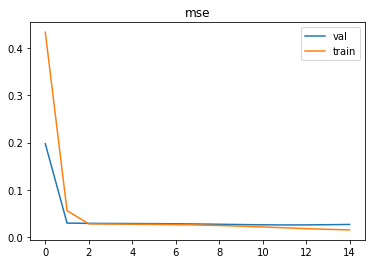

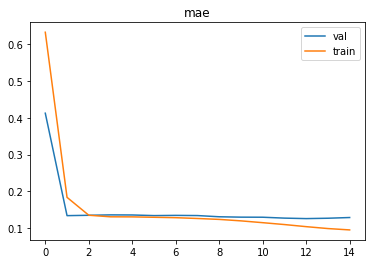

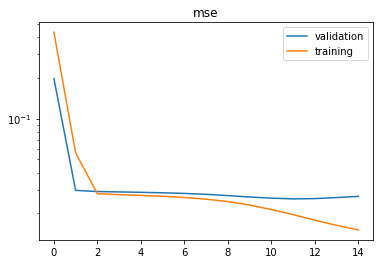

current model iteration =  1


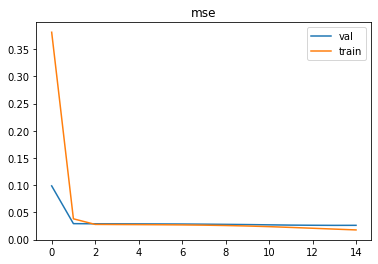

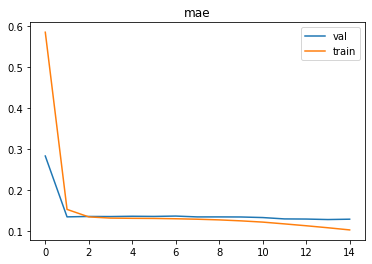

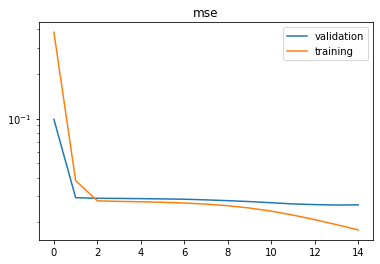

current model iteration =  2


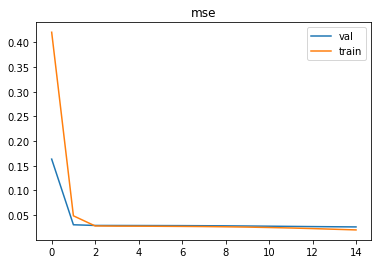

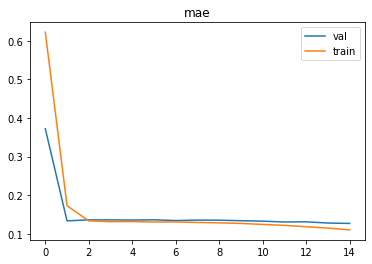

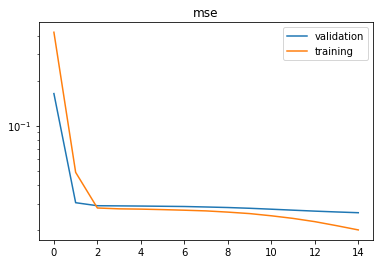

current model iteration =  3


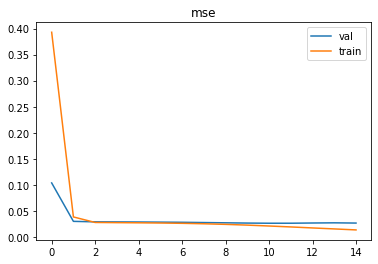

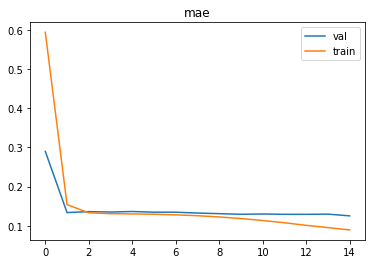

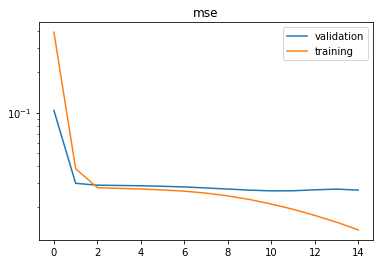

current model iteration =  4


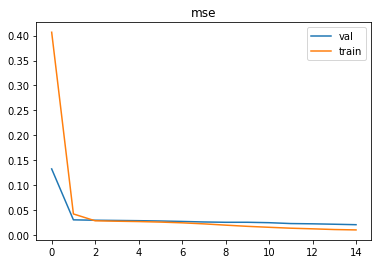

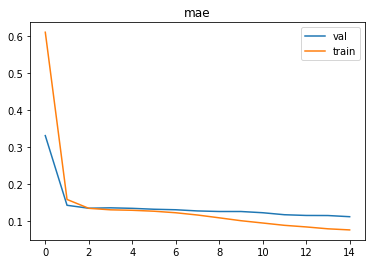

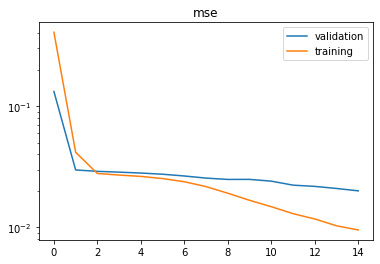

current model iteration =  5


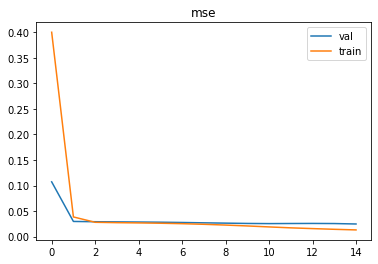

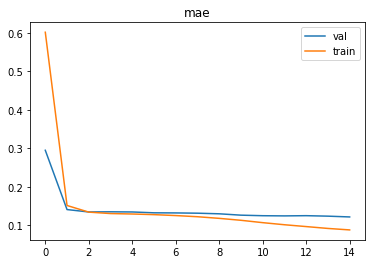

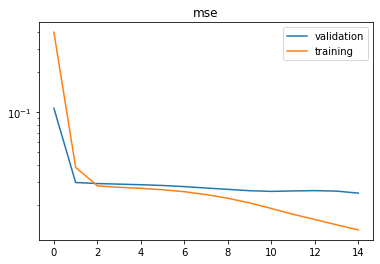

current model iteration =  6


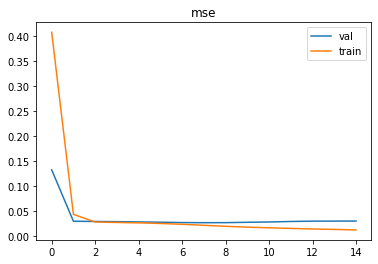

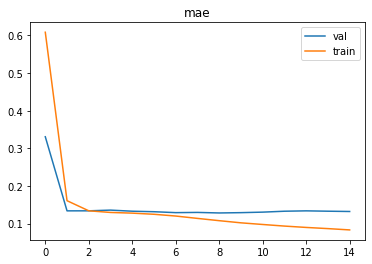

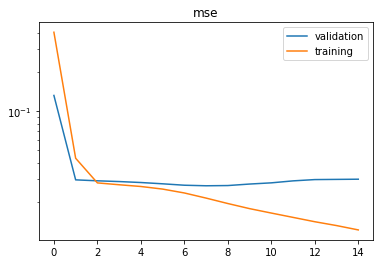

current model iteration =  7


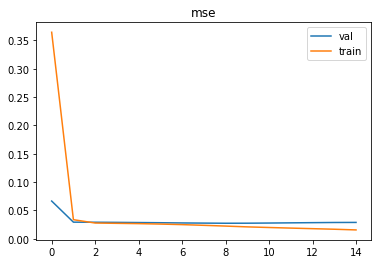

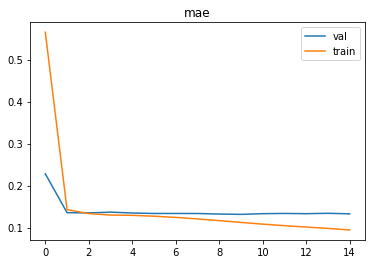

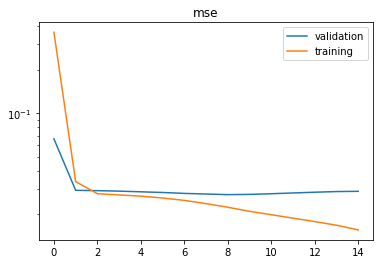

current model iteration =  8


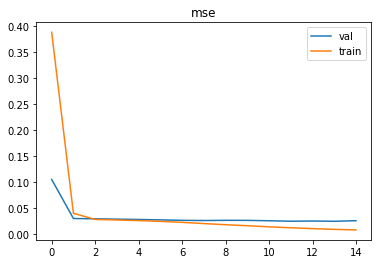

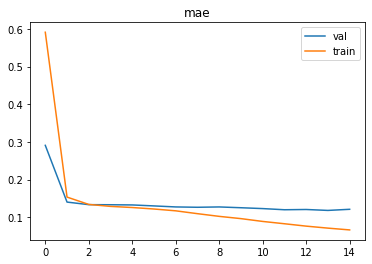

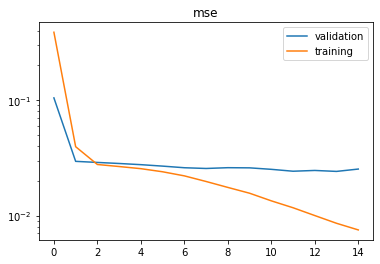

current model iteration =  9


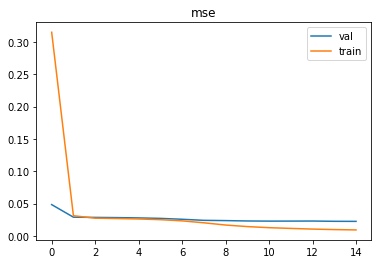

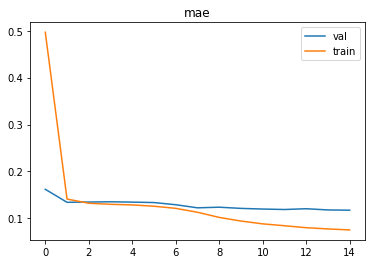

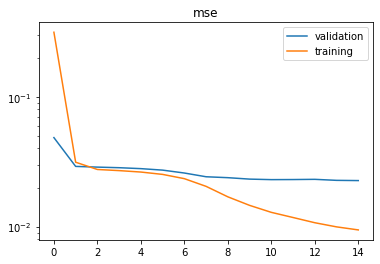

current model iteration =  10


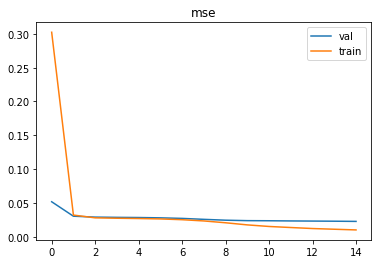

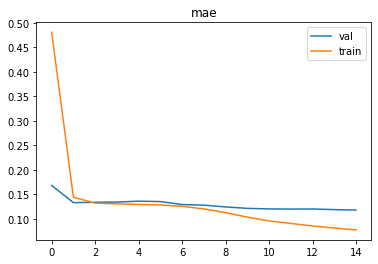

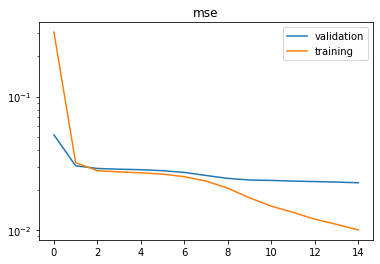

current model iteration =  11


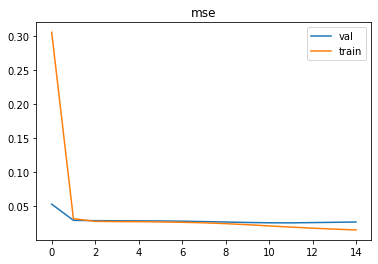

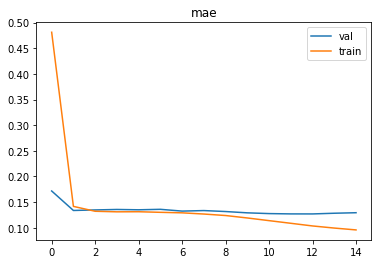

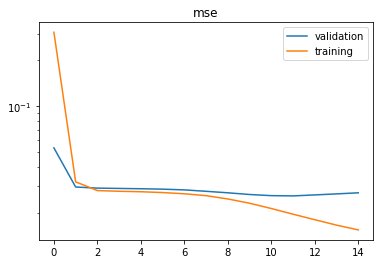

current model iteration =  12


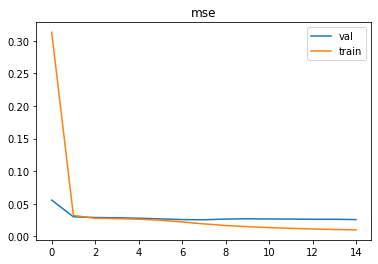

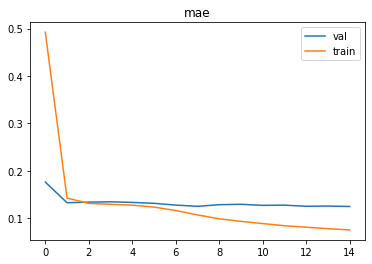

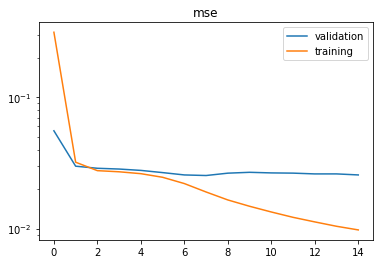

current model iteration =  13


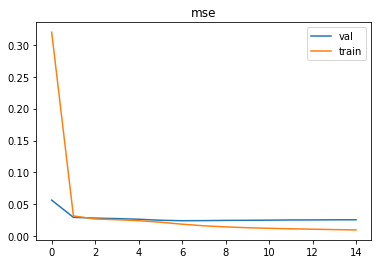

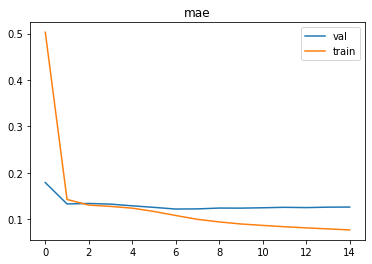

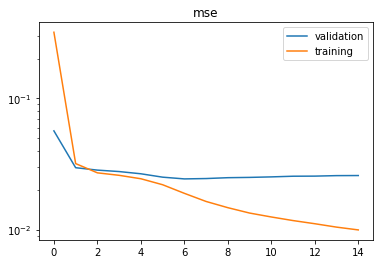

current model iteration =  14


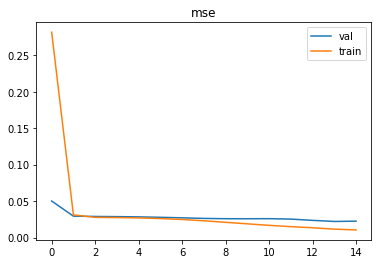

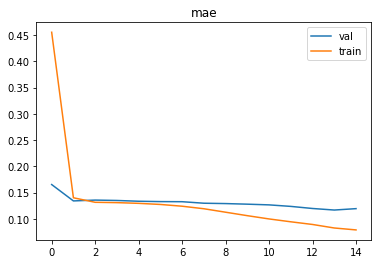

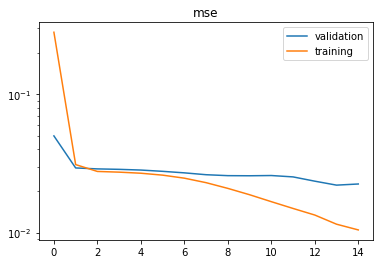

current model iteration =  15


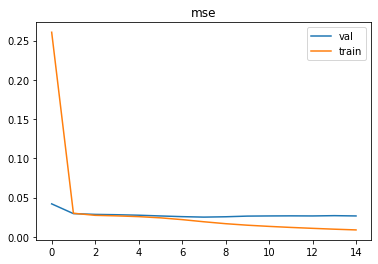

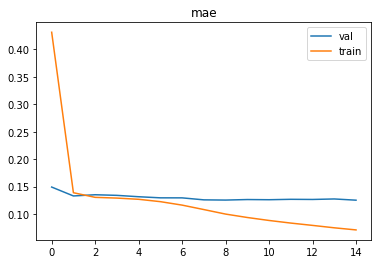

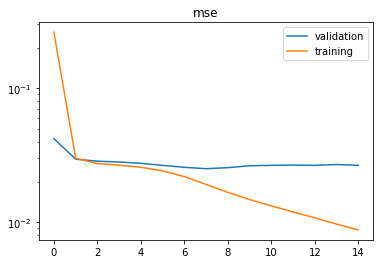

current model iteration =  16


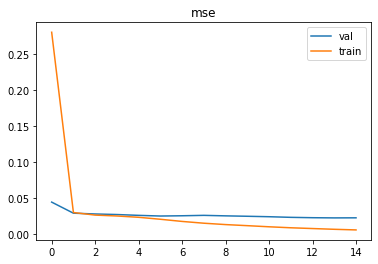

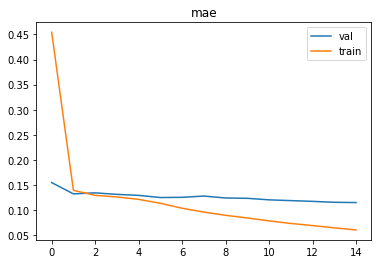

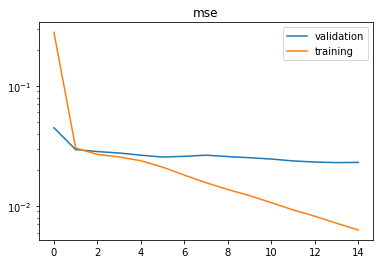

current model iteration =  17


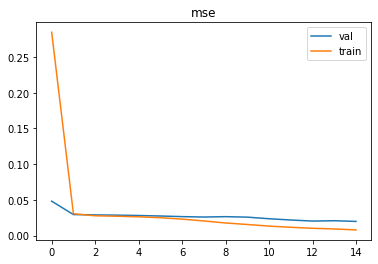

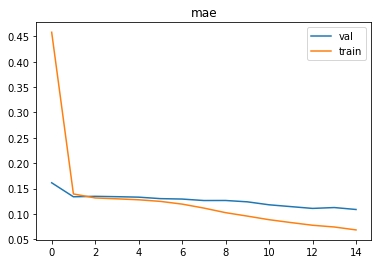

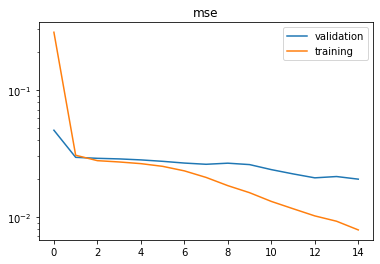

current model iteration =  18


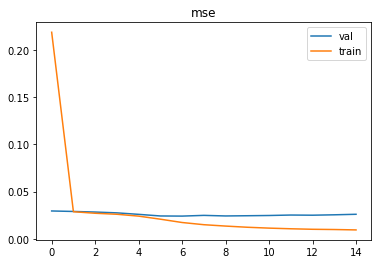

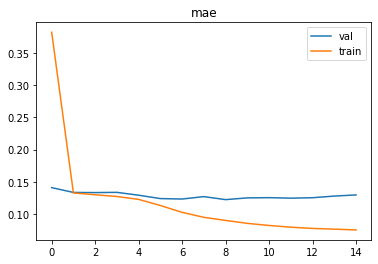

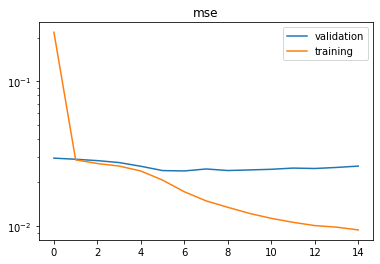

current model iteration =  19


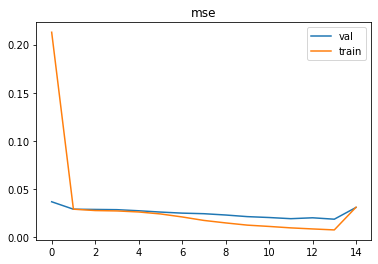

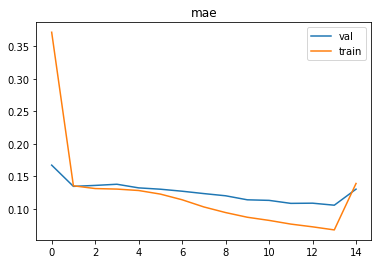

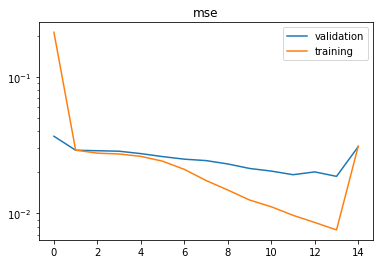

current model iteration =  20


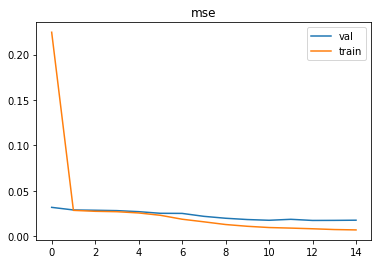

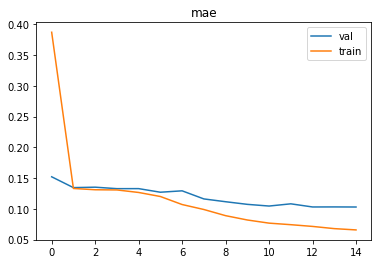

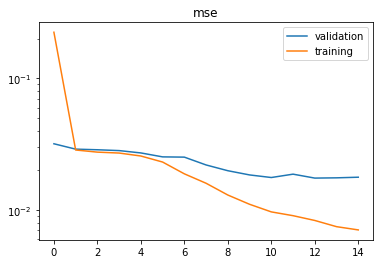

current model iteration =  21


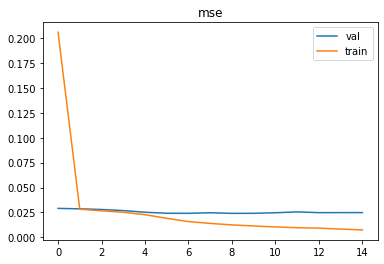

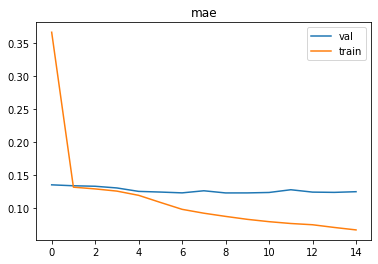

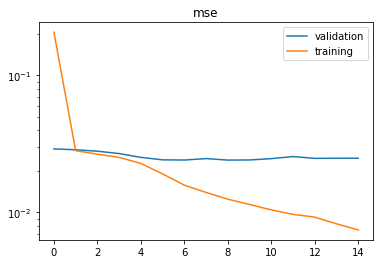

current model iteration =  22


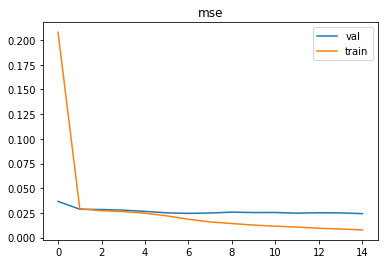

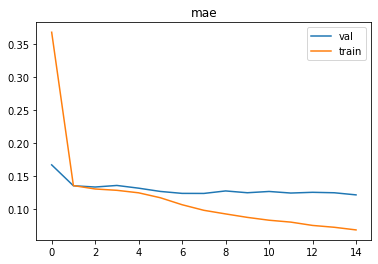

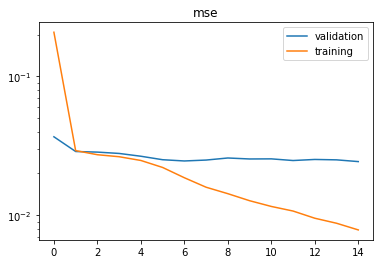

current model iteration =  23


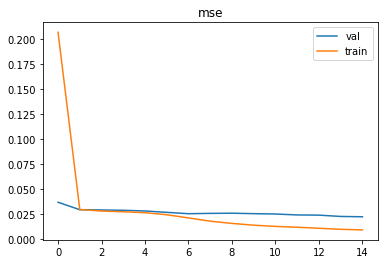

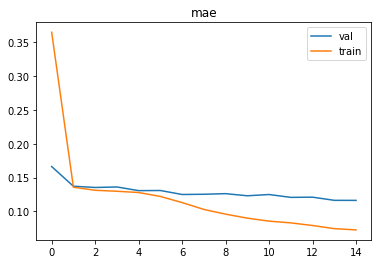

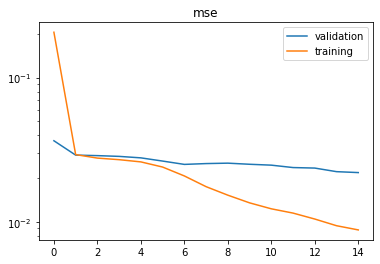

current model iteration =  24


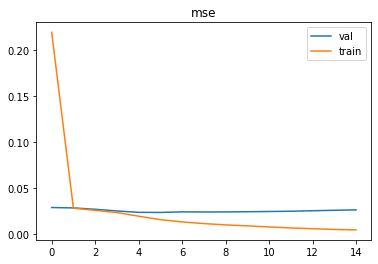

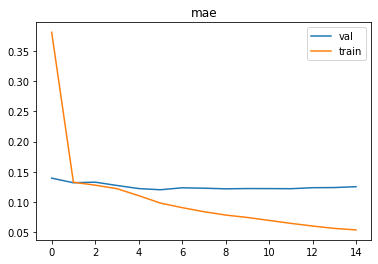

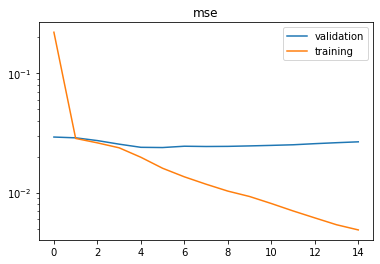

current model iteration =  25


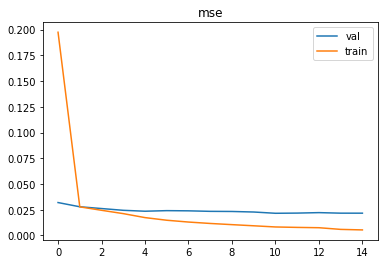

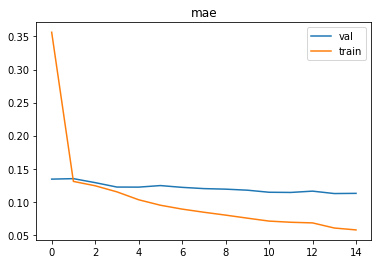

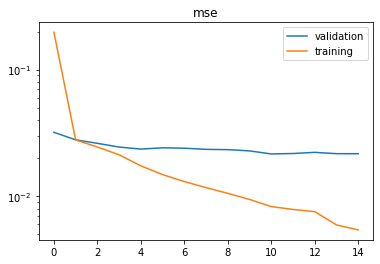

current model iteration =  26


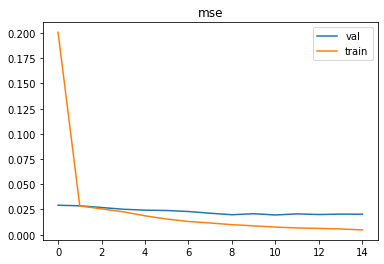

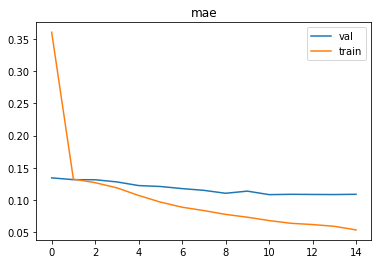

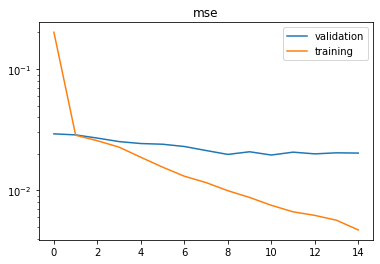

current model iteration =  27


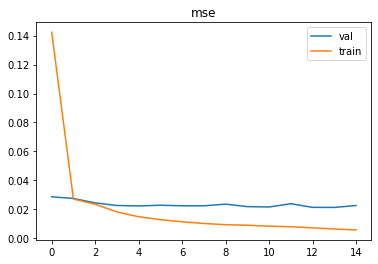

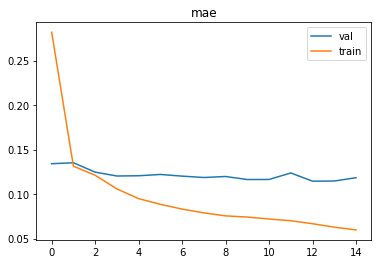

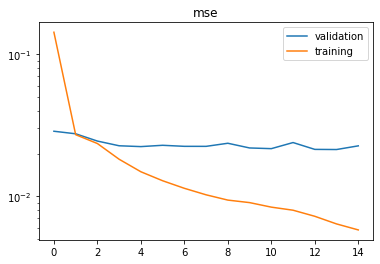

current model iteration =  28


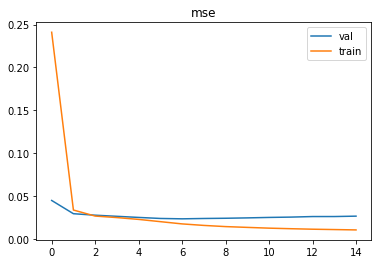

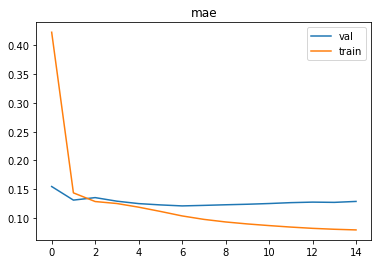

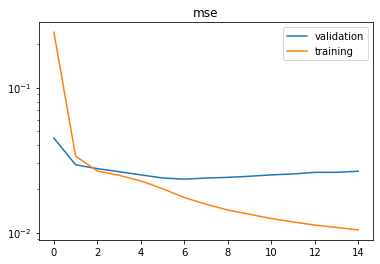

current model iteration =  29


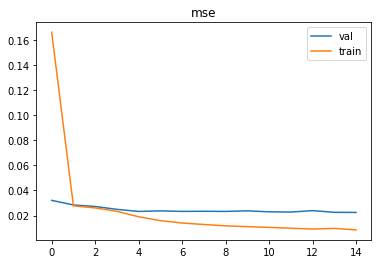

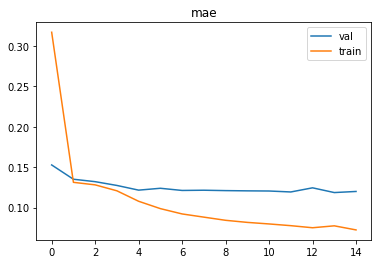

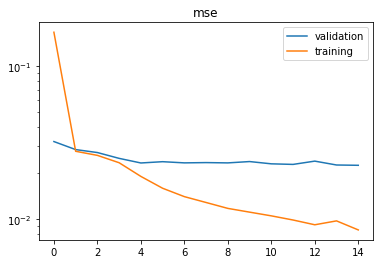

current model iteration =  30


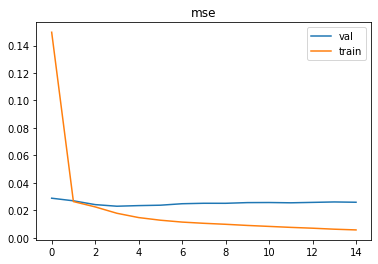

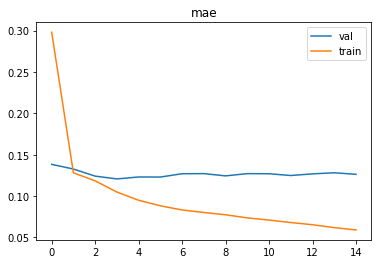

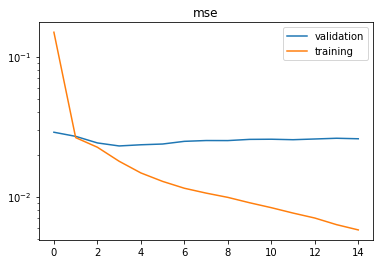

current model iteration =  31


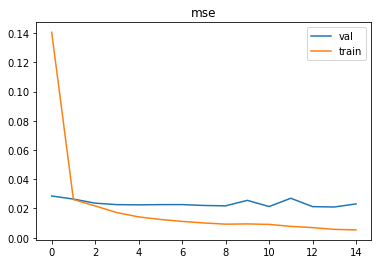

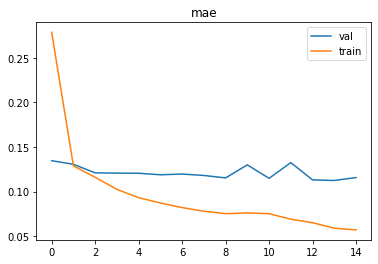

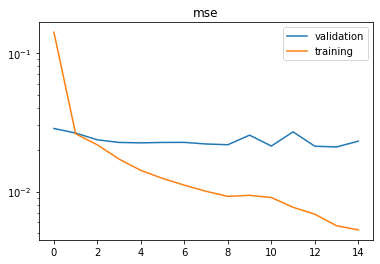

current model iteration =  32


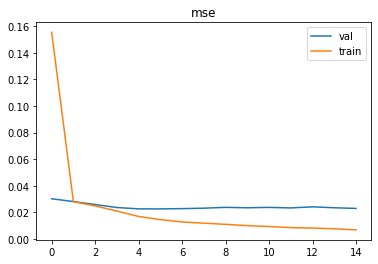

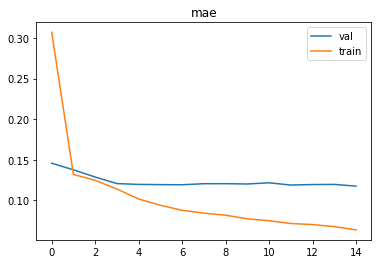

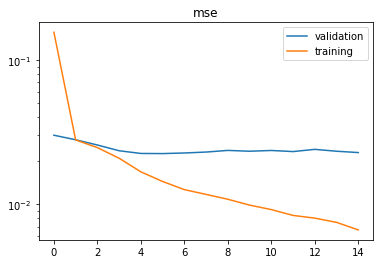

current model iteration =  33


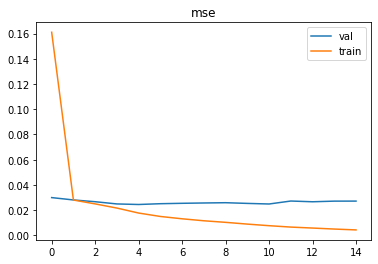

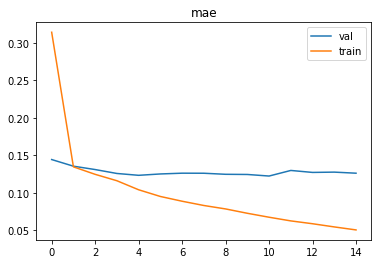

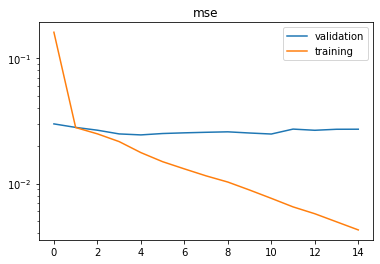

current model iteration =  34


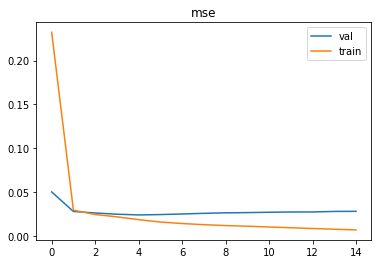

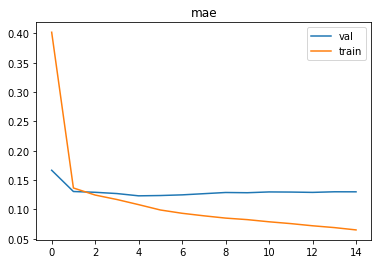

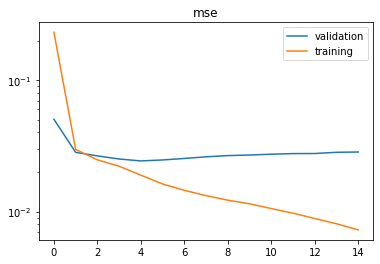

current model iteration =  35


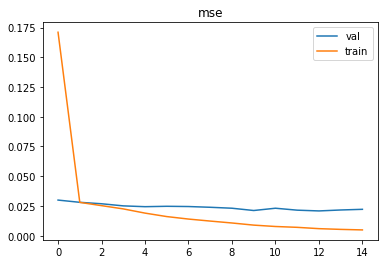

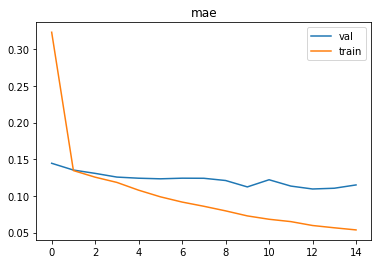

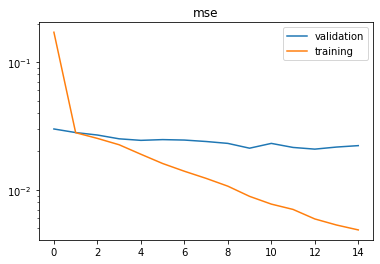

current model iteration =  36


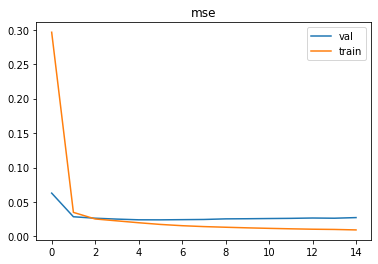

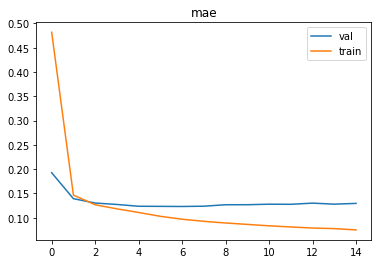

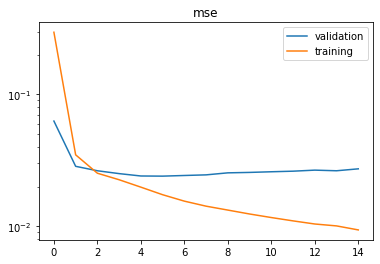

current model iteration =  37


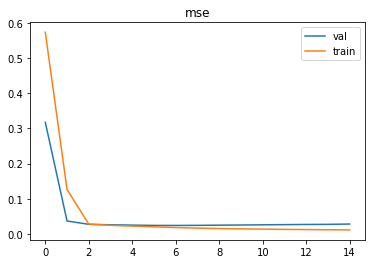

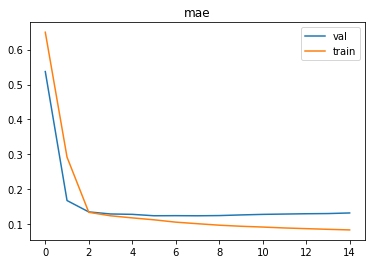

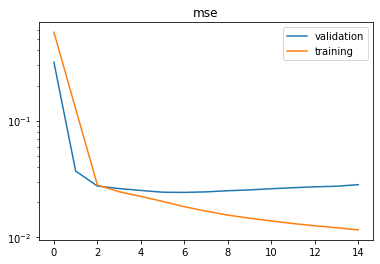

current model iteration =  38


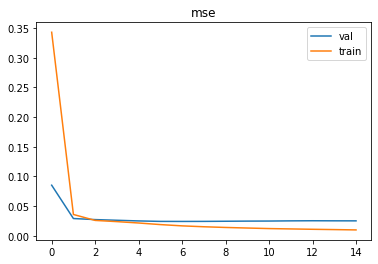

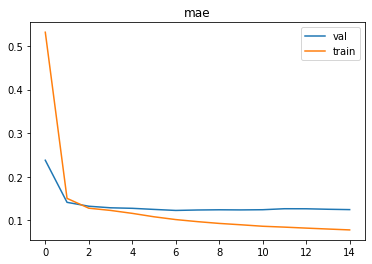

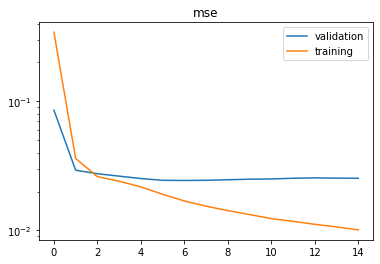

current model iteration =  39


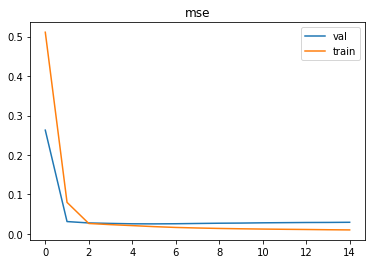

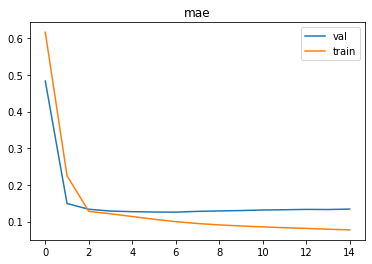

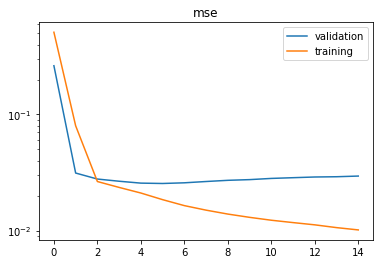

current model iteration =  40


KeyboardInterrupt: 

In [17]:
# notebook should likely be restarted after each run
K.clear_session()
build_test_run_models(epochs=15, 
                      batch_size=256, 
                      previous_completed_runs=0, 
                      verbose=0, 
                      lstm=[16, 32, 64, 128, 256], 
                      output_dims=[16, 32, 64], 
                      dropouts=[0.0, 0.1, 0.2], 
                      flatten_opts=[False])

current model iteration =  0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
4
4

Train on 8357 samples, validate on 500 samples
Epoch 1/200
8357/8357 [==============================] - ETA: 6s - loss: 0.5139 - mae: 0.6967 - mse: 0.513 - ETA: 0s - loss: 0.5156 - mae: 0.6981 - mse: 0.515 - 17s 2ms/step - loss: 0.5148 - mae: 0.6974 - mse: 0.5148 - val_loss: 0.5080 - val_mae: 0.6933 - val_mse: 0.5080
Epoch 2/200
8357/8357 [==============================] - ETA: 5s - loss: 0.5048 - mae: 0.6904 - mse: 0.504 - ETA: 0s - loss: 0.5002 - mae: 0.6868 - mse: 0.500 - 16s 2ms/step - loss: 0.4999 - mae: 0.6866 - mse: 0.4999 - val_loss: 0.4907 - val_mae: 0.6806 - val_mse: 0.4907
Epoch 3/200
8357/8357 [==============================] - ETA: 5s - loss: 0.4868 - mae: 0.6766 - mse: 0.486 - ETA: 0s - loss: 0.4821 - mae: 0.6735 - mse: 0.482 - 17s 2ms/step - loss: 0.4820 - mae: 0.6734 - mse: 0.4820 - val_loss: 0.4700 - val_mae: 0.6652 - val_mse: 0.4700
Epoch 4/200
8357/8357 

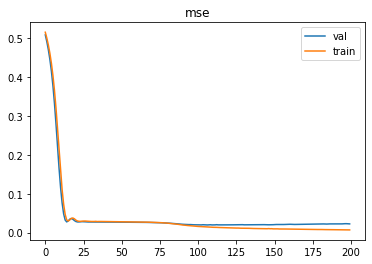

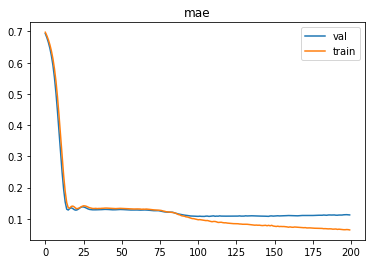

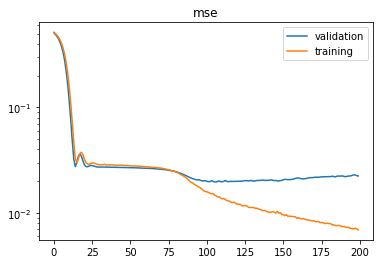

In [10]:
# Going to just train my specified model (4) because that seems to have the most potential
K.clear_session()
build_test_run_models(epochs=200, 
                      batch_size=4096, 
                      previous_completed_runs=0, 
                      verbose=1, 
#                       lstm=[[256, 128, 64], [64, 64, 64], [256, 128], [128, 64]], 
                      lstm=[ [4,4] ] ,
                      output_dims=[32], 
                      flatten_opts=[True], 
                      dropouts=[0.1], 
                      dir_base='lstm_model_13', 
                      save=True)


# evaluating models here
can make histograms of my results to see the distribution of scores predicted to the true distribution

In [14]:
loaded_lstm_model = keras.models.load_model('scoring_models/lstm_model_13_1.h5')
test_predictions = loaded_lstm_model.predict(data_valid_sequences)
print(mean_squared_error(y_pred=test_predictions, y_true=target_validation))
print(mean_absolute_error(y_pred=test_predictions, y_true=target_validation))

0.023294976956357634
0.11540568305030634


In [ ]:
test_predictions = loaded_lstm_model.predict(data_valid_sequences)
print(mean_squared_error(y_pred=test_predictions, y_true=target_validation))
print(mean_absolute_error(y_pred=test_predictions, y_true=target_validation))

In [13]:
loc = 6
print(test_predictions[loc], target_validation[loc])

[0.8183126] 0.64


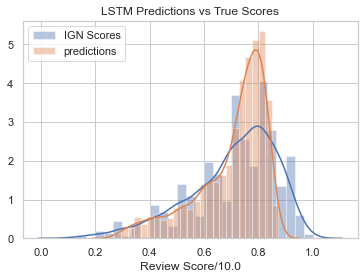

In [15]:
photo_dir = 'project_notes_or_data/photos_for_presentation/'
sns.distplot(target_validation, label='IGN Scores', axlabel='Review Score/10.0')
sns.distplot(test_predictions, label='predictions')
plt.legend()
plt.title('LSTM Predictions vs True Scores')
# plt.savefig(photo_dir+'lstm_prediction_model_13_1.jpg', dpi=200)
plt.show()

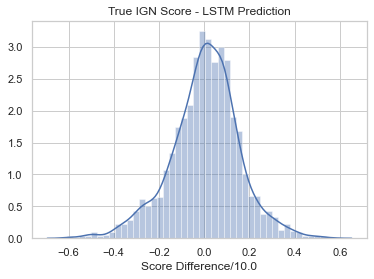

[0.83 0.6  0.8  ... 0.68 0.9  0.65]
[0.8149478  0.64183617 0.8226326  ... 0.73251677 0.76680285 0.8302503 ]


In [16]:
distance_from_score = target_validation - test_predictions[:,0]
sns.distplot(distance_from_score, axlabel='Score Difference/10.0')
plt.title('True IGN Score - LSTM Prediction')
# plt.savefig(photo_dir+'lstm_true_score_distance_13_1.jpg', dpi=200)
plt.show()

print(target_validation)
print(test_predictions[:,0])

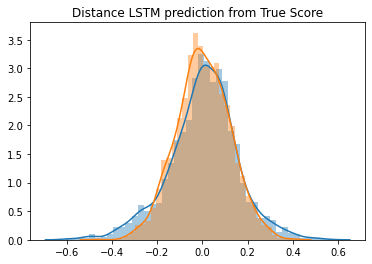

In [23]:
randos = np.random.normal(loc=0.0, scale=0.12, size=len(distance_from_score))

sns.distplot(distance_from_score, label='distance from truth')
sns.distplot(randos, label='gaussian')
plt.title('Distance LSTM prediction from True Score')
plt.savefig(photo_dir+'lstm_true_score_distance_with_gaussian_13_1.jpg', dpi=200)
plt.show()

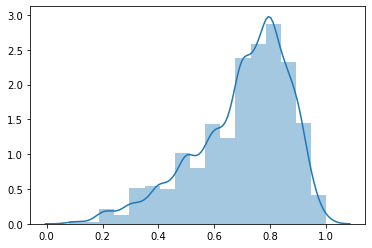

In [24]:
sns.distplot(target_train, bins=17)
plt.show()